In [10]:
import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 6)

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [11]:
b = phoebe.load("../estimations/bundle-saves/aviles-iturbide-gaia-ztf-ltt/ebai-estimates-trimmed")

In [12]:
print(b['enabled'])

ParameterSet: 13 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide_norm@ph...: True
   enabled@lc_iturbide_raw@pho...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_iturbide_aviles_...: True
   enabled@lc_gaia_g_norm@phoe...: True
   enabled@lc_gaia_rp_norm@pho...: True
   enabled@lc_gaia_bp_norm@pho...: True
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
   enabled@lcZtfG@phoebe01@com...: True
   enabled@lcZtfR@phoebe01@com...: True


In [13]:
rawGaiaDatasets = [d for d in b.datasets if 'raw' in d and 'gaia' in d]
normGaiaDatasets = [d for d in b.datasets if 'norm' in d and 'gaia' in d]
ztfDatasets = [d for d in b.datasets if 'Ztf' in d]

rawDatasetPlotGroups = [['lc_iturbide_raw'], ['lc_iturbide_aviles_raw'], rawGaiaDatasets]
normDatasetPlotGroups = [['lc_iturbide_norm'], ['lc_iturbide_aviles_norm'], normGaiaDatasets, ztfDatasets]
allDatasetPlotGroups = rawDatasetPlotGroups + normDatasetPlotGroups

100%|██████████| 3673/3673 [10:45<00:00,  5.69it/s]
Fri, 24 Nov 2023 16:11 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Fri, 24 Nov 2023 16:11 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


before_optimizers
-------------------------------------
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394763
		 lc_gaia_g_raw - 13229.17669350356
		 lc_gaia_rp_raw - 4308.280464088302
		 lc_gaia_bp_raw - 2220.4058763557696
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.687318913960486
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.863033947688
		 lc_gaia_g_norm - 13229.176693503625
		 lc_gaia_rp_norm - 4308.280464088301
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628677
		 lcZtfG - 7510.758185009429
		 lcZtfR - 24668.343851277343


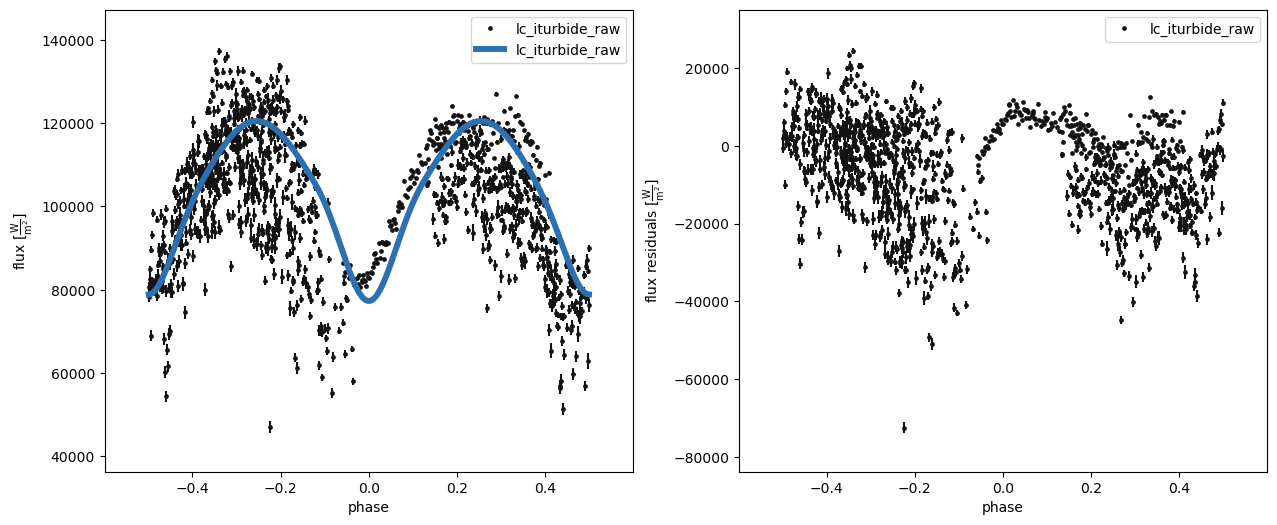

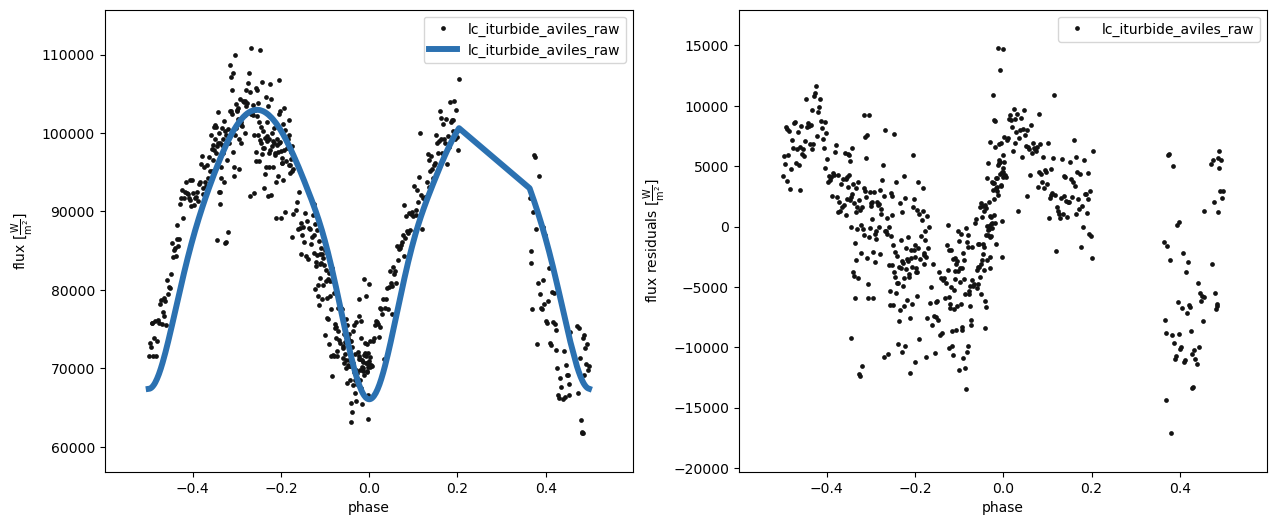

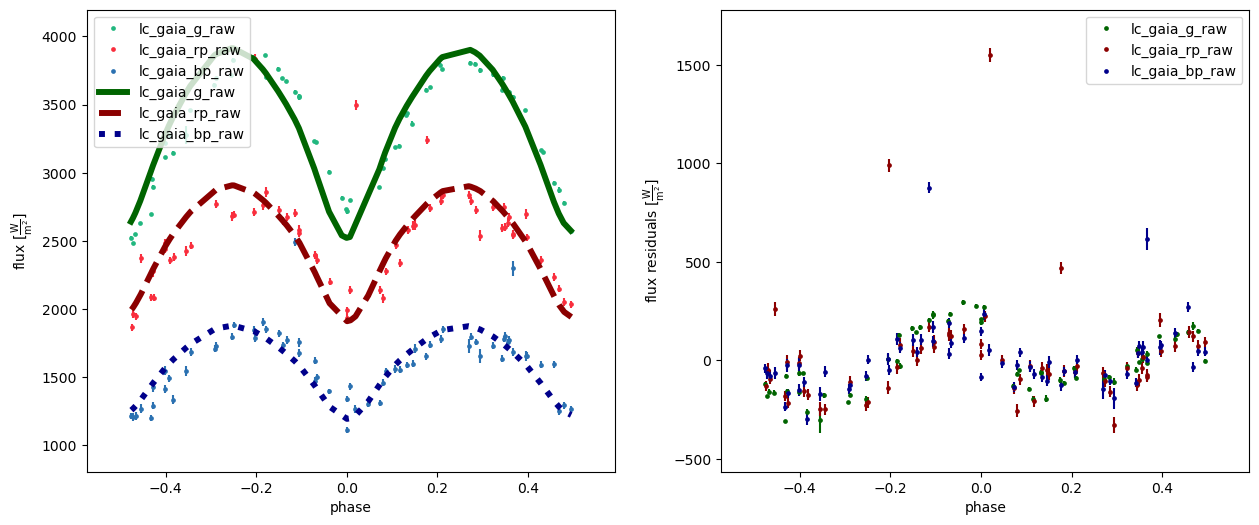

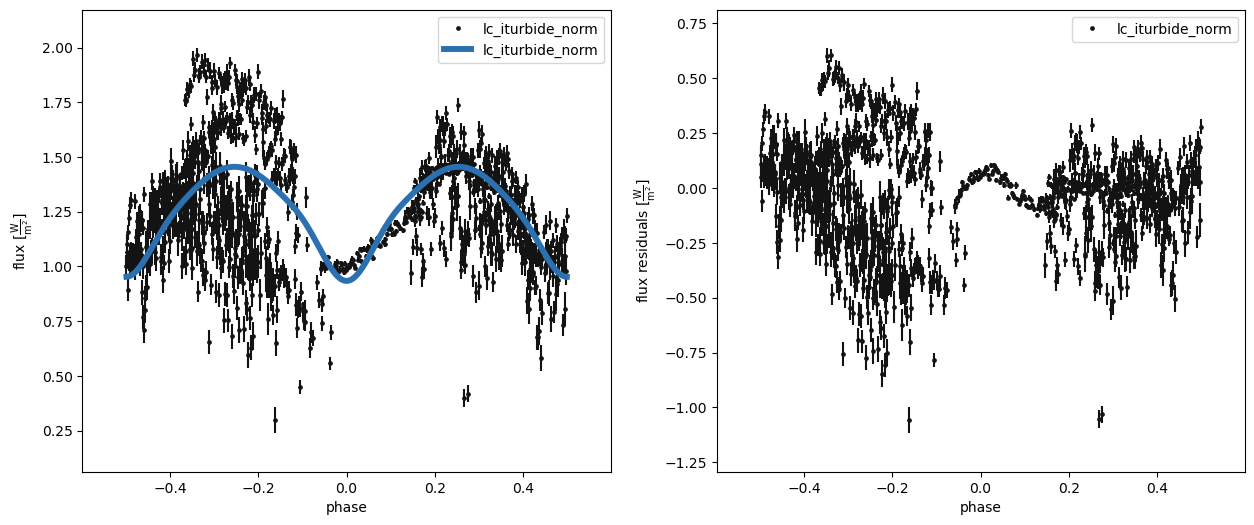

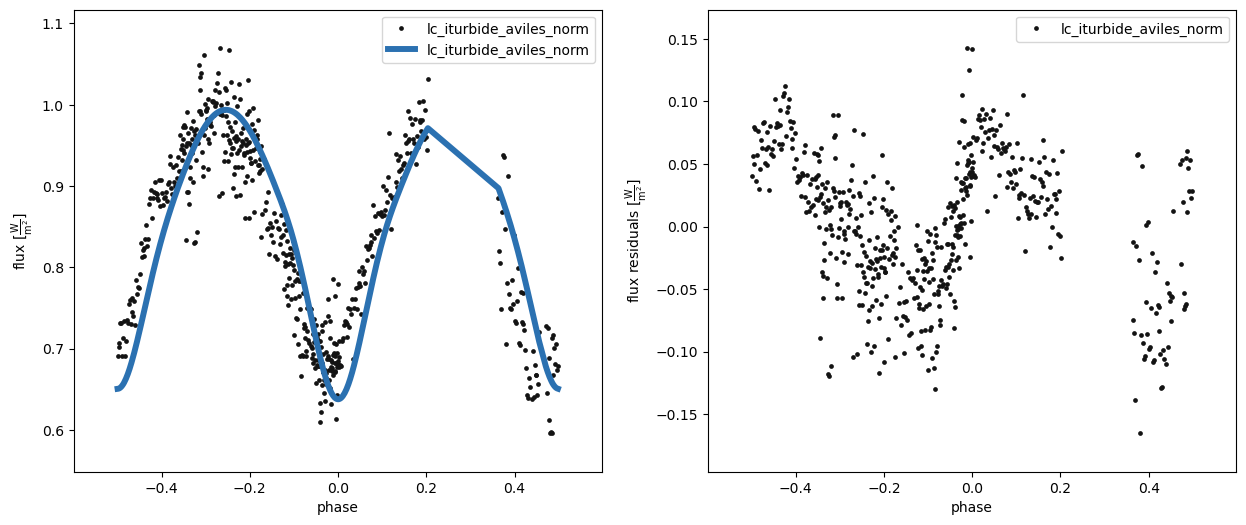

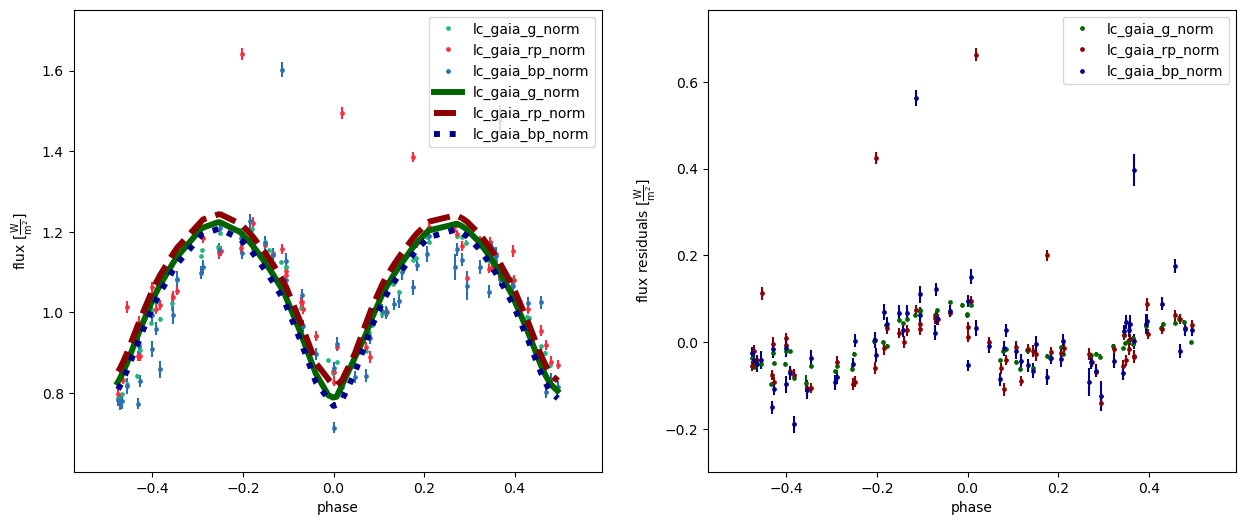

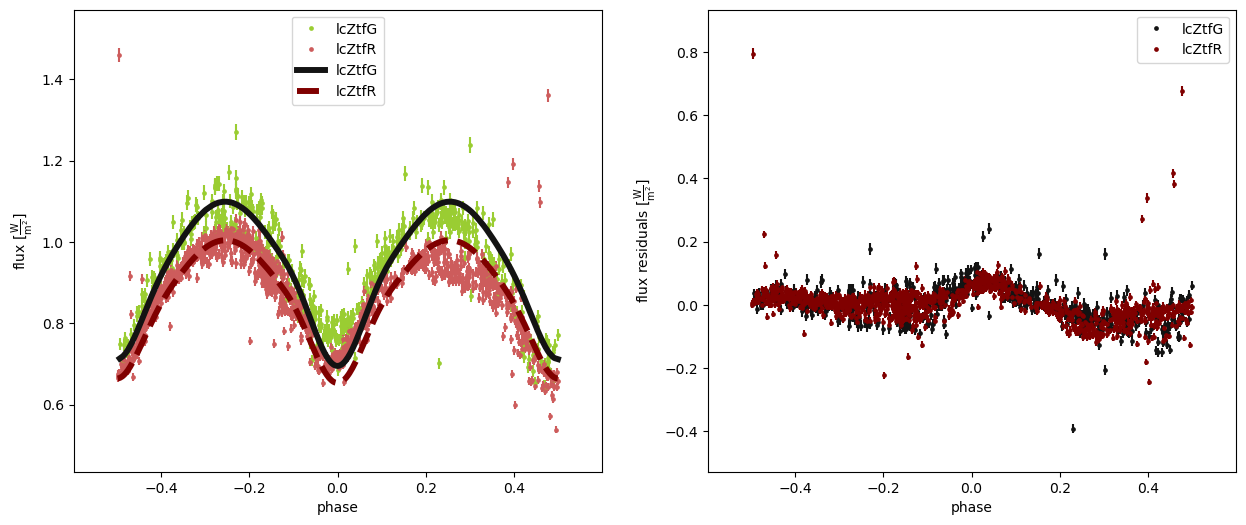

In [14]:
b.run_compute(model='before_optimizers', overwrite=True)
gen_utils.printChi2(b, 'before_optimizers')
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(15, 6), datasetGroups=allDatasetPlotGroups, model='before_optimizers')

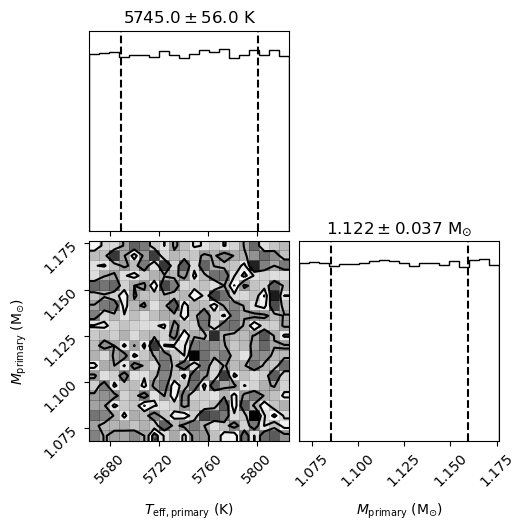

In [19]:
_ = b.plot_distribution_collection('poro_porb_bounds')

# Initial Parameters

In [16]:
print(b['q'])
print(b['mass'])
print(b['requiv'])
print(b['teff'])
print(b['teffratio'])
print(b['fillout_factor'])
print(b['incl@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 1.8564781150410867
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@binary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, period@binary@component, sma@primary@component, incl@bina

In [17]:
print(b['t0_supconj'])

Parameter: t0_supconj@binary@component
                       Qualifier: t0_supconj
                     Description: Zeropoint date at superior conjunction of the primary component
                           Value: -0.03747659625944774 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, compute_phases@mesh01@dataset, compute_phases@lc_iturbide_norm@dataset, compute_phases@lc_iturbide_raw@dataset, compute_phases@lc_iturbide_aviles_norm@dataset, compute_phases@lc_iturbide_aviles_raw@dataset, compute_phases@lc_gaia_g_norm@dataset, compute_phases@lc_gaia_rp_norm@dataset, compute_phases@lc_gaia_bp_norm@dataset, compute_phases@lc_gaia_g_raw@dataset, compute_phases@lc_gaia_rp_raw@dataset, compute_phases@lc_gaia_bp_raw@dataset, compute_phases@lcZtfG@dataset, compute_phases@lcZtfR@dataset
                      Related to: period@binary@component, ecc@binary@component, per0@binary@component, dpdt@binary@component, dperdt@b

# Period and `t0_supconj`

Eclipse timings look off from model to light curves, from slight positional offset.

In [18]:
opt_utils.optimize_params(b, fit_twigs=['period@binary', 't0_supconj'], label='per_t0', export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  datasets=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets, maxiter=200)

External Solver: ./external-jobs/iturbide-gaia-ztf-ltt/optimizer.nelder_mead_opt_per_t0.py ./results/opt_per_t0_solution


('opt_per_t0', 'opt_per_t0_solution')

Adopted:
period@binary@orbit@component = 0.33357 d
t0_supconj@binary@orbit@component = -0.03754 d

Original values:
  period@binary@orbit@component 0.333566999 d
  t0_supconj@binary@orbit@component -0.03747659625944774 d


100%|██████████| 3673/3673 [12:15<00:00,  4.99it/s]
Sun, 26 Nov 2023 23:32 BUNDLE       WARNING dataset-scaling: adopting sigmas=0.0008344892206263245 for dataset='lc_iturbide_aviles_norm'
Sun, 26 Nov 2023 23:32 BUNDLE       WARNING dataset-scaling: adopting sigmas=86.45139021561069 for dataset='lc_iturbide_aviles_raw'


before_optimizers
	 Iturbide (Aviles) (Raw) - 18109217111.55099
	 Iturbide (Full) (Raw) - 265597.22928488976
	 Gaia (Raw) - 19757.86303394763
		 lc_gaia_g_raw - 13229.17669350356
		 lc_gaia_rp_raw - 4308.280464088302
		 lc_gaia_bp_raw - 2220.4058763557696
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.687318913960486
	 Iturbide (Full) (Norm) - 43816.40841331415
	 Gaia (Norm) - 19757.863033947688
		 lc_gaia_g_norm - 13229.176693503625
		 lc_gaia_rp_norm - 4308.280464088301
		 lc_gaia_bp_norm - 2220.405876355764
	 ZTF - 32179.10203628677
		 lcZtfG - 7510.758185009429
		 lcZtfR - 24668.343851277343
opt_per_t0_model
	 Iturbide (Aviles) (Raw) - 11589742432.3405
	 Iturbide (Full) (Raw) - 211488.2178310823
	 Gaia (Raw) - 10448.924385175389
		 lc_gaia_g_raw - 4912.824726698158
		 lc_gaia_rp_raw - 3853.7444540805977
		 lc_gaia_bp_raw - 1682.3552043966338
------------------------------------------------
	 Iturbide (Aviles) (Norm) - 1.0798695213359042
	 Iturbide (

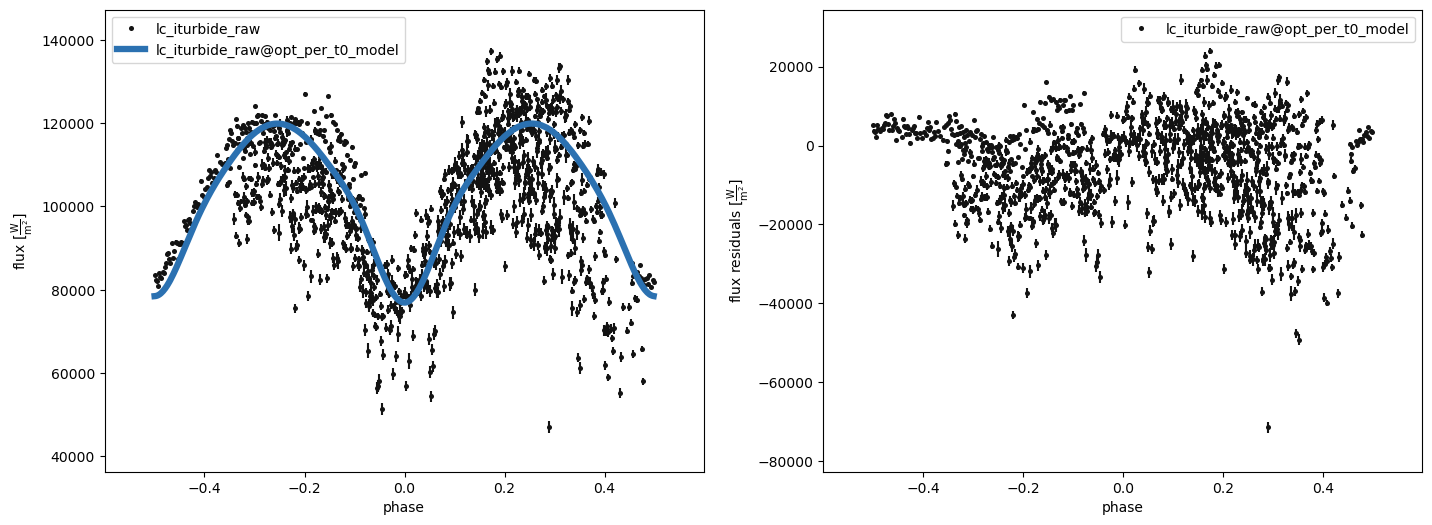

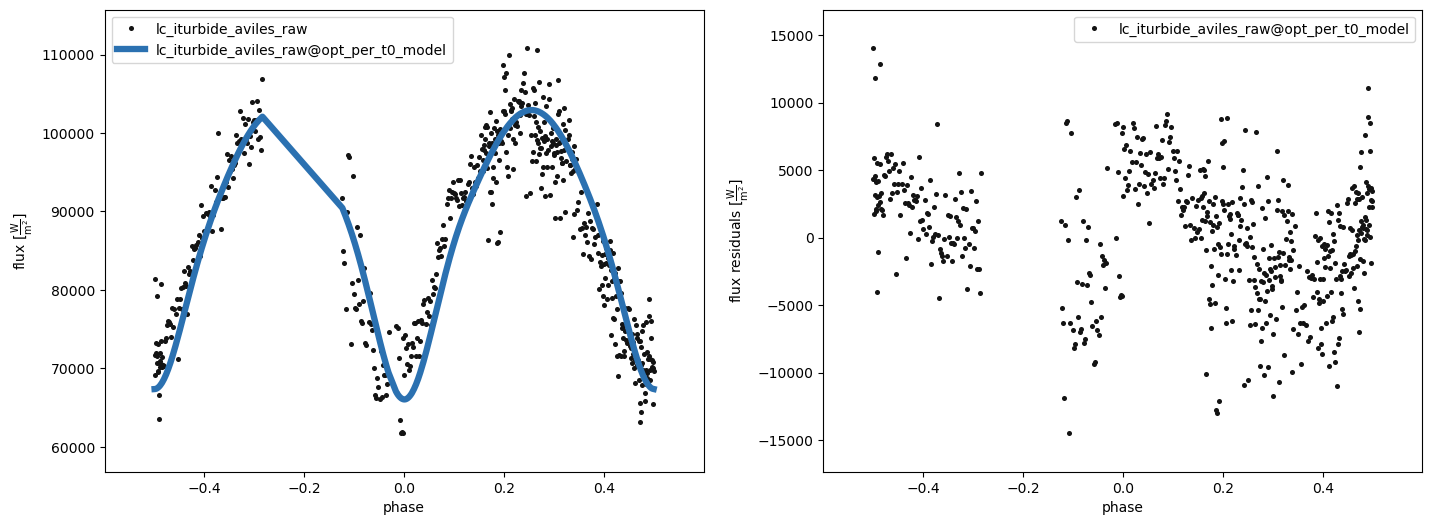

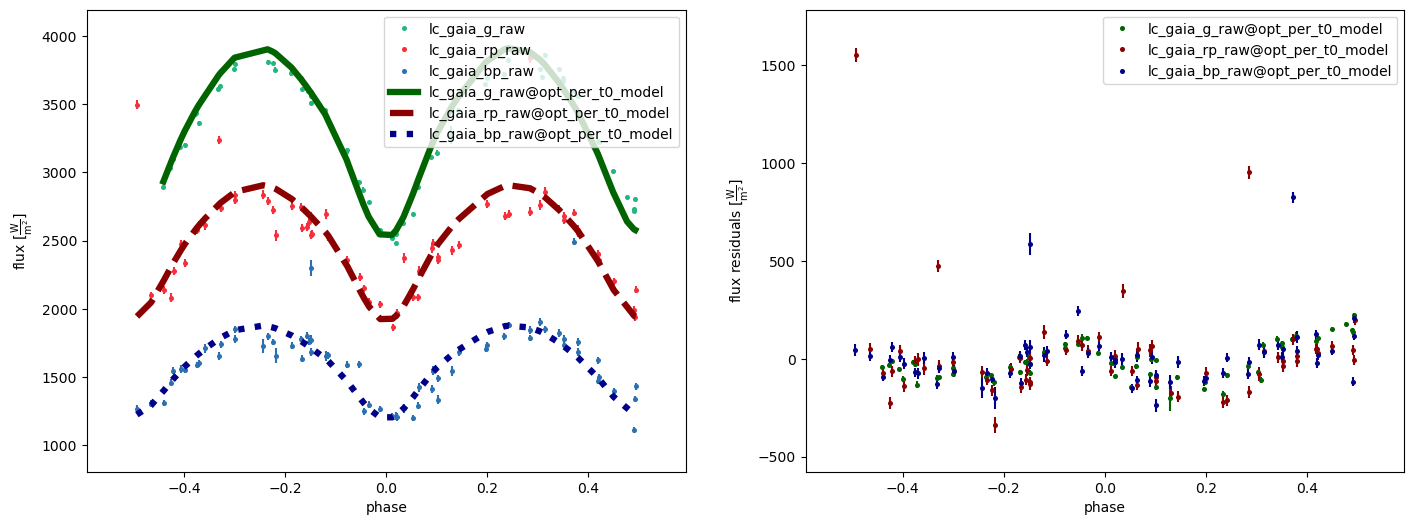

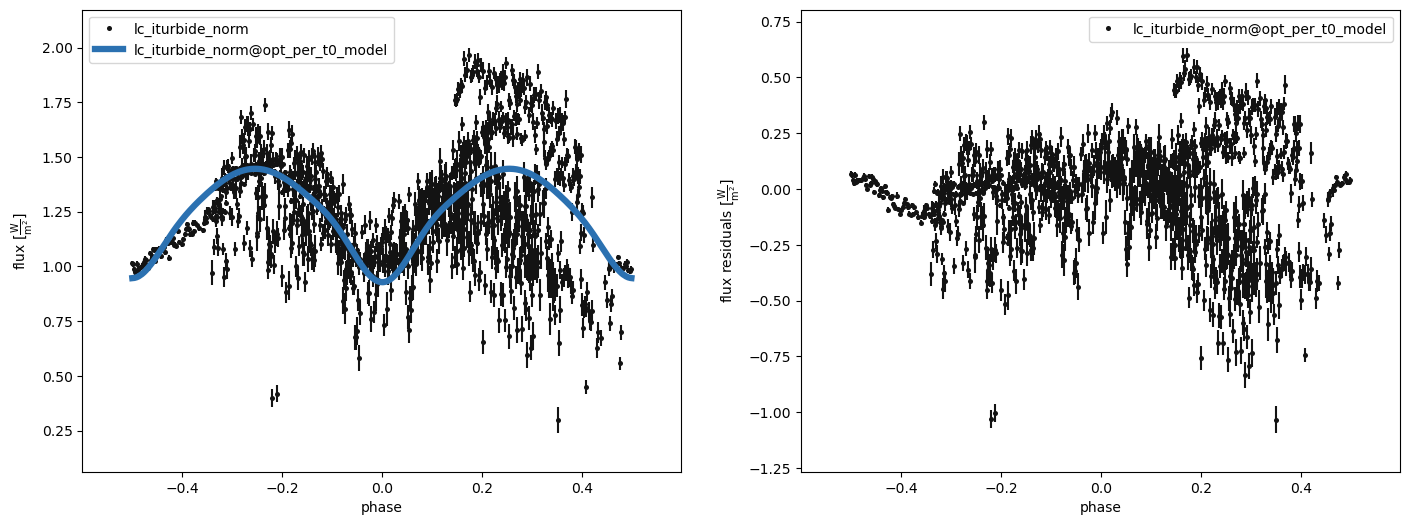

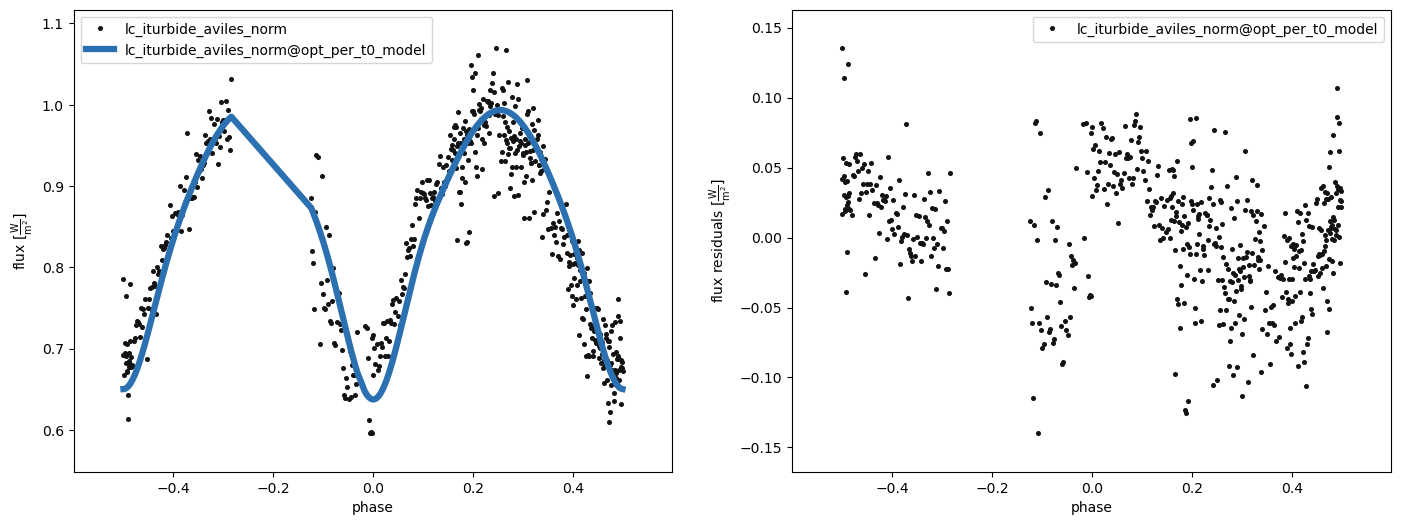

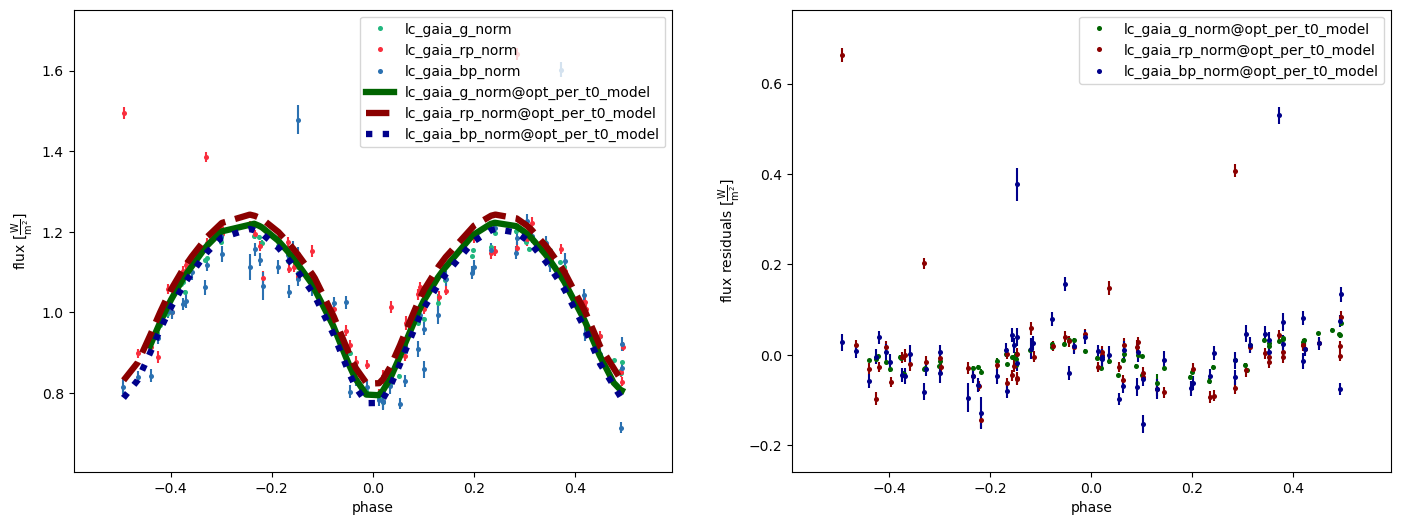

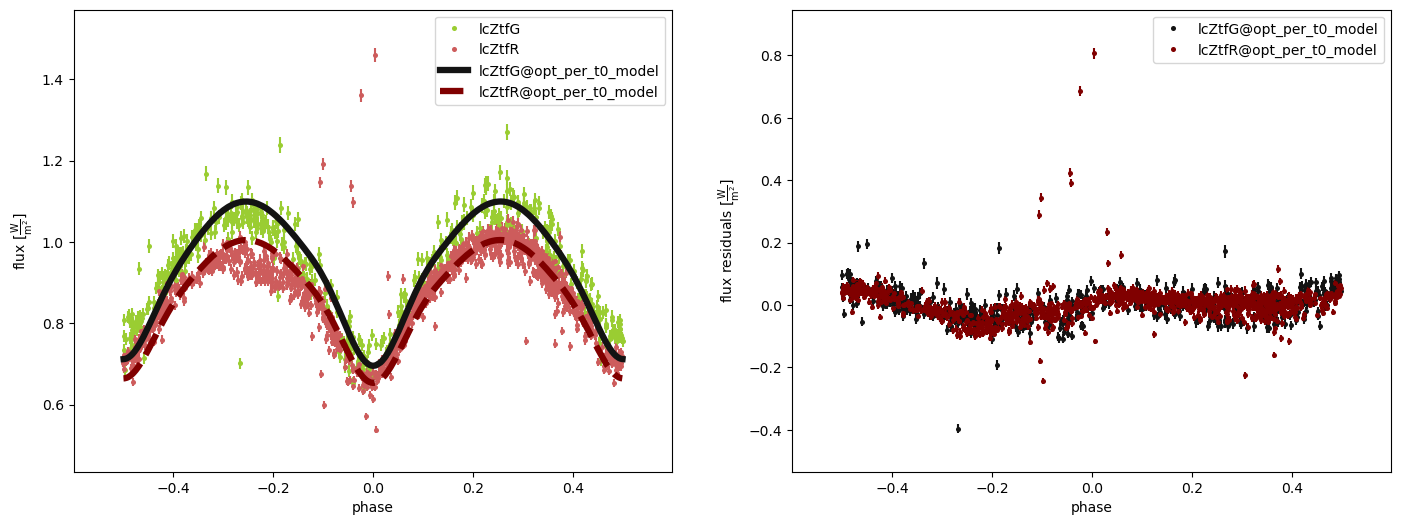

{'lc_iturbide_raw': <Figure size 1700x600 with 2 Axes>,
 'lc_iturbide_aviles_raw': <Figure size 1700x600 with 2 Axes>,
 'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1700x600 with 2 Axes>,
 'lc_iturbide_norm': <Figure size 1700x600 with 2 Axes>,
 'lc_iturbide_aviles_norm': <Figure size 1700x600 with 2 Axes>,
 'lc_gaia_g_norm-lc_gaia_rp_norm-lc_gaia_bp_norm': <Figure size 1700x600 with 2 Axes>,
 'lcZtfG-lcZtfR': <Figure size 1700x600 with 2 Axes>}

In [23]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-ltt/results/opt_per_t0_solution", reset_params=False)
gen_utils.printAllModelsChi2(b)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(17, 6), datasetGroups=allDatasetPlotGroups, model=computeModelName)

# Eclipse Width and Depth

Adjusting $T_{eff}$ ratio (`teffratio`) based on eclipse depths, alongside the fillout factor (`fillout_factor`) to adjust the eclipse widths. Fillout factor
parametrization of component radii.

In [24]:
opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], "teffr_ff", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  datasets=['lc_iturbide_norm', 'lc_iturbide_aviles_norm'] + normGaiaDatasets + ztfDatasets, maxiter=200)

External Solver: ./external-jobs/iturbide-gaia-ztf-ltt/optimizer.nelder_mead_opt_teffr_ff.py ./results/opt_teffr_ff_solution


('opt_teffr_ff', 'opt_teffr_ff_solution')

## Adjusting Component $T_{eff}$

Since these parameters are some of the last that will likely need to be adjusted for this model, here we try adjusting the component $T_{eff}$ using the color
difference from each set of light curves. The optimized temperatures will need to agree with Gaia and ZTF data, since this is where we have color information.

Will run 3 separate optimizers; one including normalized datasets only (+ZTF), one including raw datasets only (-ZTF), and one with raw datasets + ZTF normalized.

In [25]:
pb_backup = b.copy()

In [ ]:
%%script echo "skip unless need to restore from backup"
b = pb_backup.copy()

In [26]:
print(b['pblum_mode'])

ParameterSet: 12 parameters
   pblum_mode@lc_iturbide_norm...: dataset-scaled
   pblum_mode@lc_iturbide_raw@...: dataset-scaled
   pblum_mode@lc_iturbide_avil...: dataset-scaled
   pblum_mode@lc_iturbide_avil...: dataset-scaled
   pblum_mode@lc_gaia_g_norm@d...: dataset-scaled
   pblum_mode@lc_gaia_rp_norm@...: dataset-scaled
   pblum_mode@lc_gaia_bp_norm@...: dataset-scaled
   pblum_mode@lc_gaia_g_raw@da...: dataset-scaled
   pblum_mode@lc_gaia_rp_raw@d...: dataset-scaled
   pblum_mode@lc_gaia_bp_raw@d...: dataset-scaled
        pblum_mode@lcZtfG@dataset: dataset-scaled
        pblum_mode@lcZtfR@dataset: dataset-scaled


In [32]:
b.set_value_all(qualifier='pblum_mode', 
				dataset=['lc_iturbide_raw', 'lc_iturbide_norm', 'lc_iturbide_aviles_raw', 'lc_iturbide_aviles_norm', 'lc_gaia_g_raw', 'lc_gaia_g_norm', 'lcZtfG'], 
				value='component-coupled')

# coupling Gaia color LCs to Gaia_G
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='lc_gaia_g_raw')

b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_norm', 'lc_gaia_bp_norm'], value='lc_gaia_g_norm')

# coupling ZTF color to ZTF_G
b.set_value(qualifier='pblum_mode', dataset='lcZtfR', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lcZtfR', value='lcZtfG')

100%|██████████| 3673/3673 [11:16<00:00,  5.43it/s]


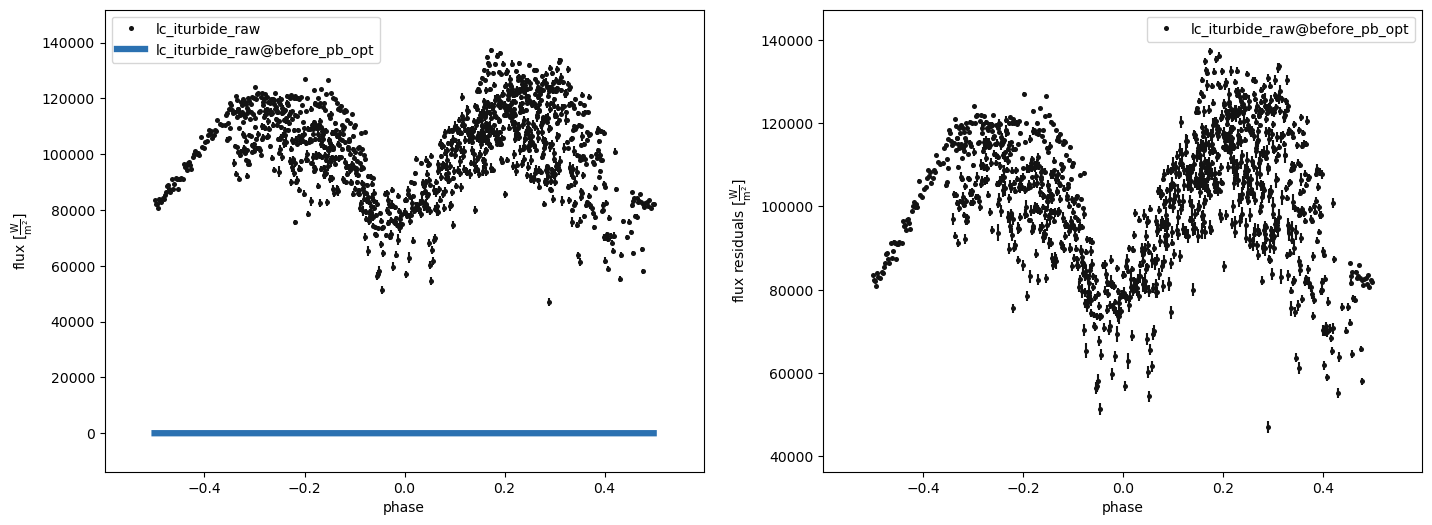

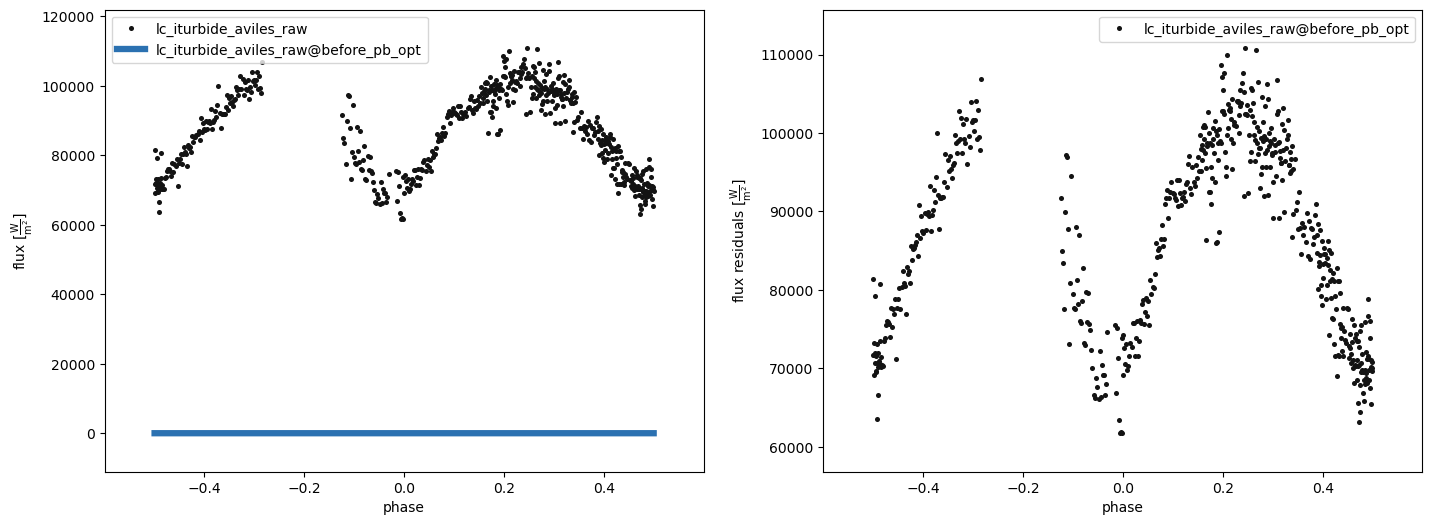

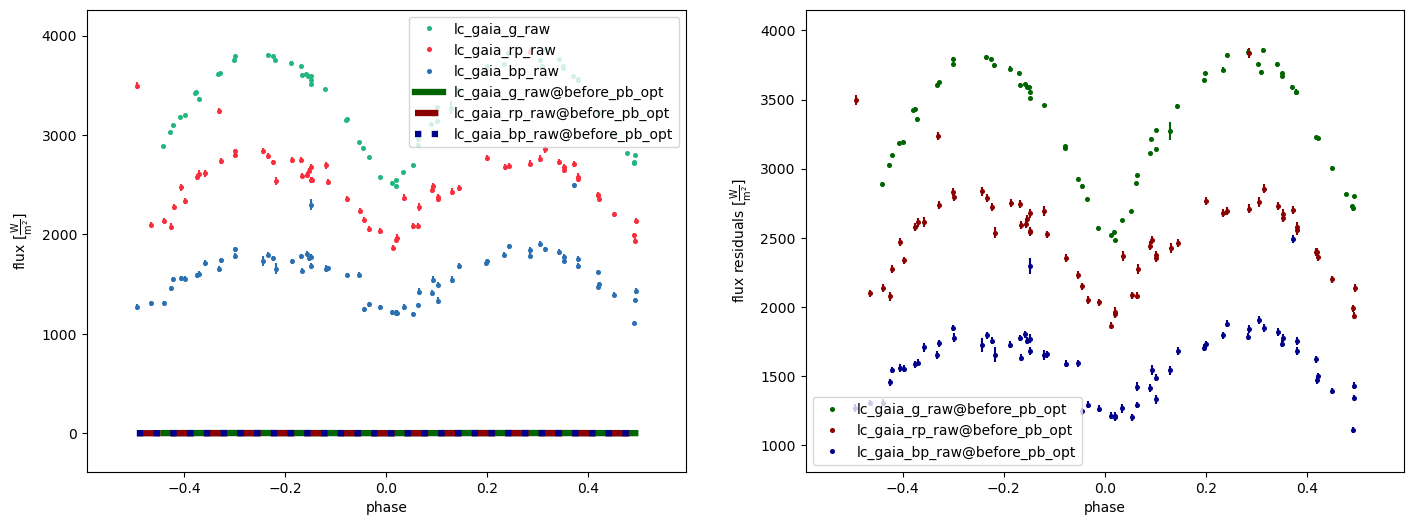

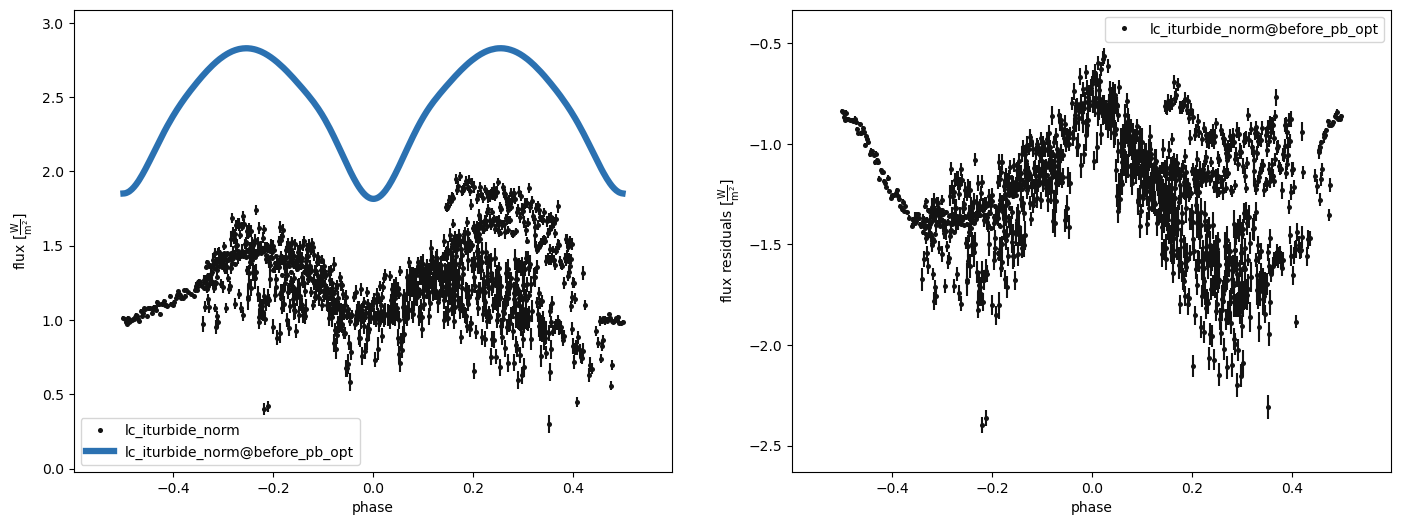

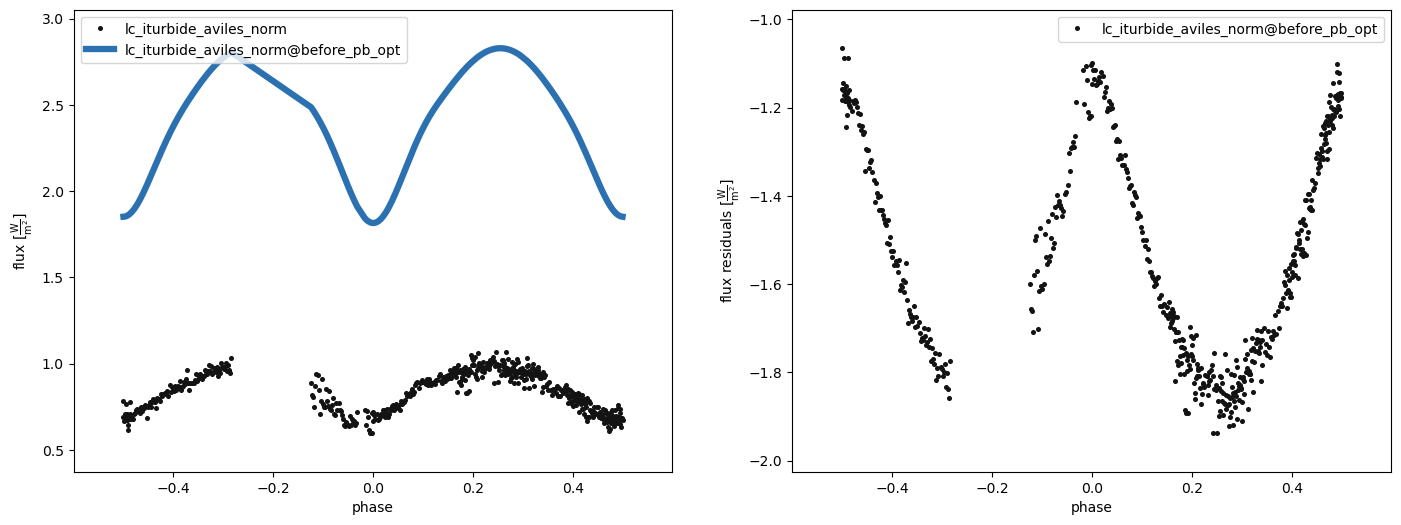

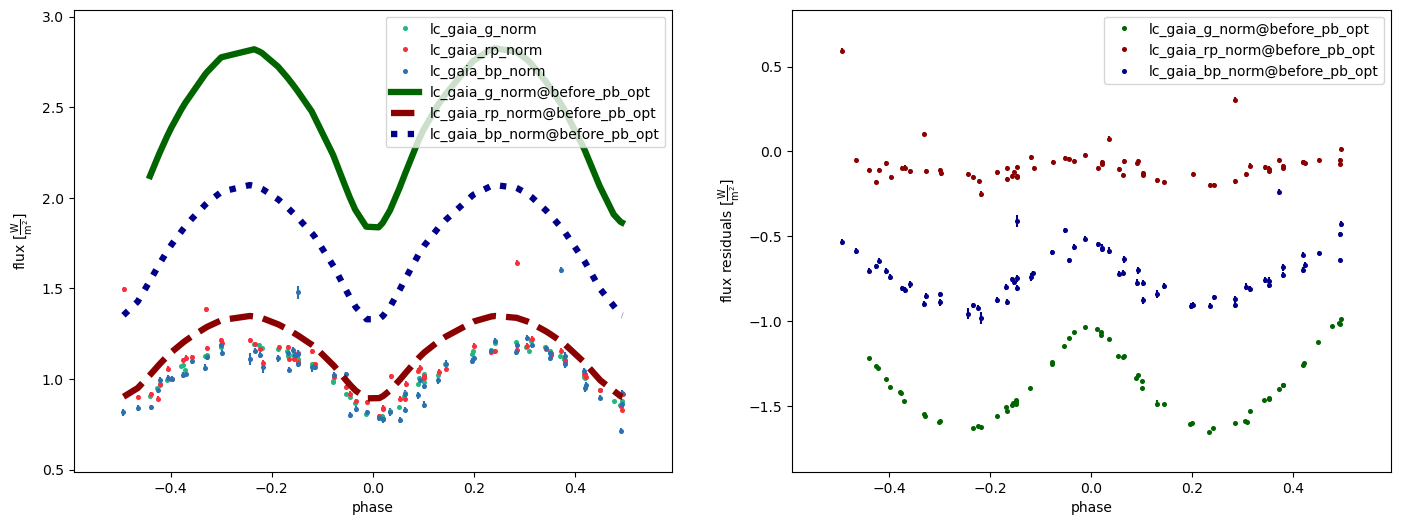

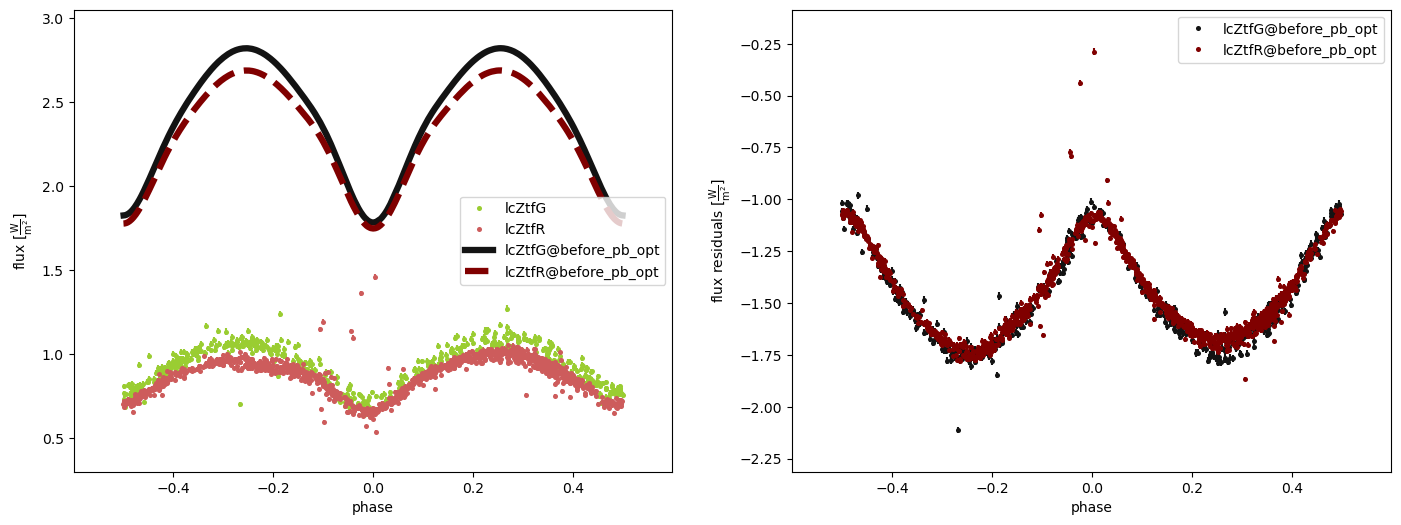

In [45]:
b.set_value_all(qualifier='enabled', value=True)
b.run_compute(model='before_pb_opt', overwrite=True)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(17, 6), datasetGroups=allDatasetPlotGroups, model='before_pb_opt')

In [39]:
# normalized datasets; excluding Aviles norm (since it's a very sparse dataset)
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_norm", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_norm', 'pblum@primary@lcZtfG', 'pblum@primary@lc_iturbide_norm'],
						  datasets=normGaiaDatasets + ztfDatasets + ['lc_iturbide_norm'], maxiter=500)

External Solver: ./external-jobs/iturbide-gaia-ztf-ltt/optimizer.nelder_mead_opt_teff_ff_pblum_iturbide_gaia_ztf_norm.py ./results/opt_teff_ff_pblum_iturbide_gaia_ztf_norm_solution


('opt_teff_ff_pblum_iturbide_gaia_ztf_norm',
 'opt_teff_ff_pblum_iturbide_gaia_ztf_norm_solution')

In [41]:
# raw datasets only
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw'],
						  datasets=rawGaiaDatasets + ['lc_iturbide_raw'], maxiter=500)

External Solver: ./external-jobs/iturbide-gaia-ztf-ltt/optimizer.nelder_mead_opt_teff_ff_pblum_iturbide_gaia_raw.py ./results/opt_teff_ff_pblum_iturbide_gaia_raw_solution


('opt_teff_ff_pblum_iturbide_gaia_raw',
 'opt_teff_ff_pblum_iturbide_gaia_raw_solution')

In [44]:
# raw + ZTF
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw', 'pblum@primary@lcZtfG'],
						  datasets=rawGaiaDatasets + ztfDatasets + ['lc_iturbide_raw'], maxiter=500)

External Solver: ./external-jobs/iturbide-gaia-ztf-ltt/optimizer.nelder_mead_opt_teff_ff_pblum_iturbide_gaia_ztf_raw.py ./results/opt_teff_ff_pblum_iturbide_gaia_ztf_raw_solution


('opt_teff_ff_pblum_iturbide_gaia_ztf_raw',
 'opt_teff_ff_pblum_iturbide_gaia_ztf_raw_solution')